# Imports

In [1]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

from src.model import *
from src.attack import get_gradient, gradient_inversion
from src.utils import show_reconstructions

# Set Random Seed

In [2]:
def init_seed(seed, reproducibility):
    r""" init random seed for random functions in numpy, torch, cuda and cudnn

    Args:
        seed (int): random seed
        reproducibility (bool): Whether to require reproducibility
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if reproducibility:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    else:
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

In [3]:
init_seed(2022, True)

# Model and Dataset Settings

In [4]:
model = 'SMLP'
DATAPATH = './data/'
dataset = 'CIFAR10' # CIFAR10, CIFAR100, MEDICAL_MNIST
NUM_IMGS_TO_ATTACK = 2
ASR_THRESHOLD = 0.6
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

if dataset == 'CIFAR10':
    CIFAR10_MEAN = [0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
    CIFAR10_STD = [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]
    dm = torch.as_tensor(CIFAR10_MEAN)[:, None, None].to(device)
    ds = torch.as_tensor(CIFAR10_STD)[:, None, None].to(device)
    num_classes = 10
elif dataset == 'CIFAR100':
    CIFAR100_MEAN = [0.5070783 , 0.48655024, 0.44091797]
    CIFAR100_STD = [0.26733464, 0.25643906, 0.2761504]
    dm = torch.as_tensor(CIFAR100_MEAN)[:, None, None].to(device)
    ds = torch.as_tensor(CIFAR100_STD)[:, None, None].to(device)
    num_classes = 100
elif dataset == 'MEDICAL_MNIST':
    MEDICAL_MNIST_MEAN = [0.35834864]
    MEDICAL_MNIST_STD = [0.2821981]
    dm = torch.as_tensor(MEDICAL_MNIST_MEAN)[:, None, None].to(device)
    ds = torch.as_tensor(MEDICAL_MNIST_STD)[:, None, None].to(device)
    num_classes = 6

# Test Privacy of Untrained Models

## Load Victim Data
Victim data consists of the 128 randomly sampled images and labels from the training dataset that are attacked in the paper.

In [5]:
if dataset == 'CIFAR10':
    data = torch.load('data/128CIF_RECDATA.dict')['images'].to(device)
    labels = torch.load('data/128CIF_RECDATA.dict')['labels'].to(device)
    hideen = 768
elif dataset == 'CIFAR100':
    data = torch.load('data/128CIF100_RECDATA.dict')['images'].to(device)
    labels = torch.load('data/128CIF100_RECDATA.dict')['labels'].to(device)
    hideen = 768
elif dataset == 'MEDICAL_MNIST':
    data = torch.load('data/128MED-MNI_RECDATA.dict')['images'].to(device)
    labels = torch.load('data/128MED-MNI_RECDATA.dict')['labels'].to(device)
    hideen = 3072

data_shape = data.shape[1:]

## Attack Untrained Models using IGA or NRA

In [6]:
def record_metric(img, img_rc, metric_dict, threshold=0.6):
    mse = mean_squared_error(img, img_rc)
    psnr = peak_signal_noise_ratio(img, img_rc, data_range=np.max(img))
    ssim = structural_similarity(img, img_rc, channel_axis=0)
    
    metric_dict['MSE'].append(max(0, mse))
    metric_dict['PSNR'].append(max(0, psnr))
    metric_dict['SSIM'].append(max(0, ssim))
    metric_dict['ASR'].append(1 if ssim >= threshold else 0)

It: 0. Rec. loss: 0.8475.
It: 500. Rec. loss: 0.0068.
It: 1000. Rec. loss: 0.0075.
It: 1500. Rec. loss: 0.0060.
It: 2000. Rec. loss: 0.0121.
It: 2500. Rec. loss: 0.0108.
It: 3000. Rec. loss: 0.0088.
It: 3500. Rec. loss: 0.0088.
It: 4000. Rec. loss: 0.0089.
It: 4500. Rec. loss: 0.0082.
It: 5000. Rec. loss: 0.0090.
It: 5500. Rec. loss: 0.0082.
It: 6000. Rec. loss: 0.0090.
It: 6500. Rec. loss: 0.0088.
Choosing optimal result ...
Optimal result score: 0.0090
Total time: 24.422810077667236.
It: 0. Rec. loss: 0.9757.
It: 500. Rec. loss: 0.5627.
It: 1000. Rec. loss: 0.5906.
It: 1500. Rec. loss: 0.5716.
It: 2000. Rec. loss: 0.6308.
It: 2500. Rec. loss: 0.5854.
It: 3000. Rec. loss: 0.5637.
It: 3500. Rec. loss: 0.6042.
It: 4000. Rec. loss: 0.5733.
It: 4500. Rec. loss: 0.5754.
It: 5000. Rec. loss: 0.5362.
It: 5500. Rec. loss: 0.5383.
It: 6000. Rec. loss: 0.5676.
It: 6500. Rec. loss: 0.5743.
Choosing optimal result ...
Optimal result score: 0.6481
Total time: 37.14022707939148.
It: 0. Rec. loss: 1

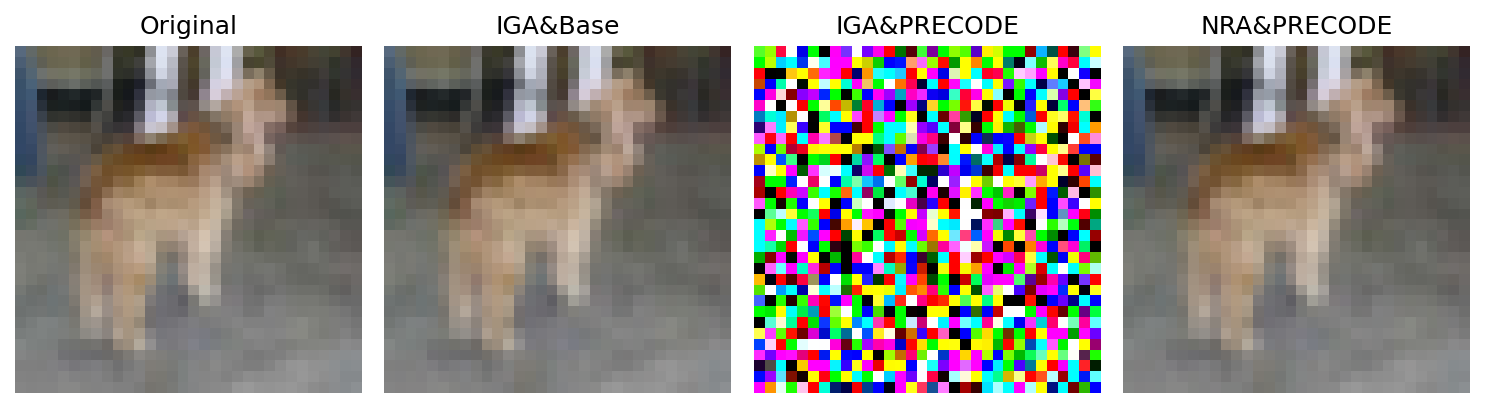

It: 0. Rec. loss: 0.8455.
It: 500. Rec. loss: 0.0048.
It: 1000. Rec. loss: 0.0021.
It: 1500. Rec. loss: 0.0031.
It: 2000. Rec. loss: 0.0032.
It: 2500. Rec. loss: 0.0004.
It: 3000. Rec. loss: 0.0004.
It: 3500. Rec. loss: 0.0000.
It: 4000. Rec. loss: 0.0000.
It: 4500. Rec. loss: 0.0000.
It: 5000. Rec. loss: 0.0000.
It: 5500. Rec. loss: 0.0000.
It: 6000. Rec. loss: 0.0000.
It: 6500. Rec. loss: 0.0000.
Choosing optimal result ...
Optimal result score: 0.0000
Total time: 24.411226987838745.
It: 0. Rec. loss: 0.8938.
It: 500. Rec. loss: 0.6028.
It: 1000. Rec. loss: 0.5711.
It: 1500. Rec. loss: 0.5605.
It: 2000. Rec. loss: 0.5937.
It: 2500. Rec. loss: 0.5311.
It: 3000. Rec. loss: 0.6039.
It: 3500. Rec. loss: 0.4665.
It: 4000. Rec. loss: 0.5513.
It: 4500. Rec. loss: 0.5730.
It: 5000. Rec. loss: 0.5138.
It: 5500. Rec. loss: 0.5939.
It: 6000. Rec. loss: 0.5679.
It: 6500. Rec. loss: 0.6329.
Choosing optimal result ...
Optimal result score: 0.5241
Total time: 36.842395305633545.
It: 0. Rec. loss: 

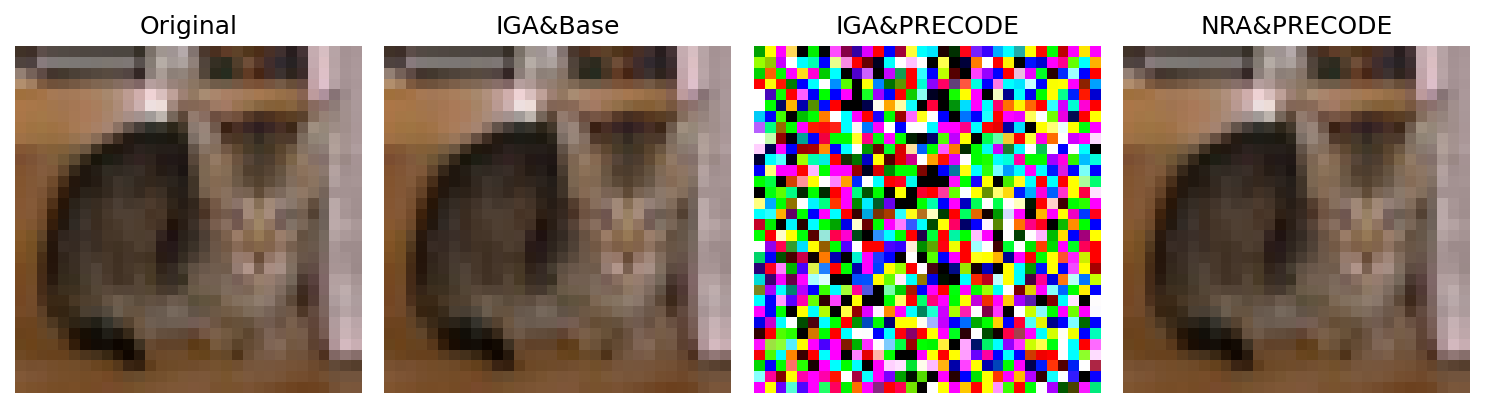

In [7]:
if model.startswith('LeNet'):
    if model == 'LeNet':
        model_base = LeNet
        model_vb = VBLeNet
    else:
        model_base = LeNetR
        model_vb = VBLeNetR
    base = model_base(num_classes=num_classes, hideen=hideen, channel=data_shape[0]).to(device)
    vb = model_vb(num_classes=num_classes, hideen=hideen, channel=data_shape[0]).to(device)
else:
    if model == 'SMLP':
        model_base = SMLP
        model_vb = VBSMLP
    elif model == 'DMLP':
        model_base = DMLP
        model_vb = VBDMLP
    base = model_base(num_classes=num_classes, data_shape=data_shape).to(device)
    vb = model_vb(num_classes=num_classes, data_shape=data_shape).to(device)

base.eval()
vb.eval()

#build inversefed library specific config for the reconstruction attack
config = dict(signed=True,
            boxed=True,
            cost_fn='sim',
            indices='def',
            weights='equal',
            lr=0.01,
            optim='adam',
            restarts=1,
            max_iterations=7000,
            total_variation=1e-6,
            init='randn',
            filter='none',
            lr_decay=True,
            scoring_choice='loss',
            )

reconstructed_images_base = []
reconstructed_images_vb = []
reconstructed_images_nra = []

metric_dict_base = defaultdict(list)
metric_dict_vb= defaultdict(list)
metric_dict_nra = defaultdict(list)
mse_eps_list = []

for i, (image, label) in enumerate(zip(data, labels)):
    label = label.unsqueeze(0)
    base_gradient = get_gradient(base, image.unsqueeze(0), label, False, True)
    vb_gradient = get_gradient(vb, image.unsqueeze(0), label, True, True)
    image_np = image.cpu().numpy()
    # IGA & Base
    base_output_reconstruction = gradient_inversion(base_gradient, label, base, data_shape, dm, ds, config).squeeze(0)
    reconstructed_images_base.append(base_output_reconstruction)
    image_rc_base = base_output_reconstruction.cpu().numpy()
    record_metric(image_np, image_rc_base, metric_dict_base, ASR_THRESHOLD)
    # IGA & PRECODE
    vb_output_reconstruction = gradient_inversion(vb_gradient, label, vb, data_shape, dm, ds, config).squeeze(0)
    reconstructed_images_vb.append(vb_output_reconstruction)
    image_rc_vb = vb_output_reconstruction.cpu().numpy()
    record_metric(image_np, image_rc_vb, metric_dict_vb, ASR_THRESHOLD)
    # NRA & PRECODE
    nra_output_reconstruction, eps = gradient_inversion(vb_gradient, label, vb, data_shape, dm, ds, config, K=256)
    nra_output_reconstruction = nra_output_reconstruction.squeeze(0)
    reconstructed_images_nra.append(nra_output_reconstruction)
    image_rc_nra = nra_output_reconstruction.cpu().numpy()
    record_metric(image_np, image_rc_nra, metric_dict_nra, ASR_THRESHOLD)
    mse_eps_list.append(mean_squared_error(vb.VB.eps_first.cpu().numpy(), eps.cpu().numpy()))
    vb.VB.eps_first = None
    print(f"Image {i:3}: SSIM IGA&Base {metric_dict_base['SSIM'][-1]:.5f} | SSIM IGA&PRECODE {metric_dict_vb['SSIM'][-1]:.5f} | SSIM NRA&PRECODE {metric_dict_nra['SSIM'][-1]:.5f}")
    show_reconstructions([image, base_output_reconstruction, vb_output_reconstruction, nra_output_reconstruction], dm, ds)
    
    if i == NUM_IMGS_TO_ATTACK-1:
        break   

## Summary of Attack Results

In [8]:
def get_result(metric_dict, name):
    return pd.DataFrame(dict([(m, np.mean(v)) for m, v in metric_dict.items()]), index=[name])

In [9]:
pd.concat([get_result(metric_dict_base, "IGA&Base"), get_result(metric_dict_vb, "IGA&PRECODE"), get_result(metric_dict_nra, "NRA&PRECODE")])

,MSE,PSNR,SSIM,ASR
IGA&Base,0.000037,60.429677,0.999843,1.0
IGA&PRECODE,3.740131,0.055654,0.000000,0.0
NRA&PRECODE,0.000032,51.251587,0.999929,1.0


In [10]:
print(f"Mean mse-ε for reconstructions NRA&PRECODE: {np.mean(mse_eps_list)}")

Mean mse-ε for reconstructions NRA&PRECODE: 8.195249802962662e-05
